# Resampling

In [1]:
%matplotlib inline

In [2]:
import random
import math

import h5py
import numpy as np
import matplotlib.pyplot as plt

import spectraldl.utils as utils

In [3]:
f = h5py.File('data/data.hdf5')
spectra = f['spectra']

In [4]:
START = 6519
END = 6732
N_CLASSES = 3

## Sample-rate Conversion

Sample-rate conversion it the process of changing the
sampling rate of discrete signal to get new representation
of the underlying continuous signal. The sampling rate
can be either increased (upsampling) or decreased
(decimation).

In [5]:
foo, bar = random.sample(list(spectra.values()), 2)
foo, bar

(<HDF5 dataset "vc220016": shape (2, 1757), type "<f4">,
 <HDF5 dataset "tg140020": shape (2, 1757), type "<f4">)

In [6]:
foo_waves, foo_fluxes = utils.cut_spectrum(foo[0], foo[1], START, END)
bar_waves, bar_fluxes = utils.cut_spectrum(bar[0], bar[1], START, END)
foo_waves.shape, bar_waves.shape

((830,), (830,))

In [7]:
foo_waves[0], bar_waves[0]

(6519.2056, 6519.019)

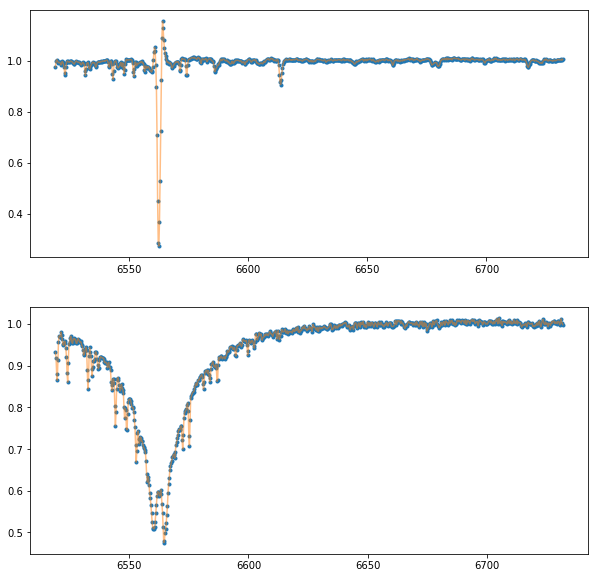

In [8]:
def resampling_plot(waves_1, fluxes_1, waves_2, fluxes_2):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.plot(waves_1, fluxes_1, '.')
    ax1.plot(waves_1, fluxes_1, alpha=0.5)
    ax2.plot(waves_2, fluxes_2, '.')
    ax2.plot(waves_2, fluxes_2, alpha=0.5)

resampling_plot(foo_waves, foo_fluxes, bar_waves, bar_fluxes)

In [9]:
def resample_spectrum(new_waves, waves, fluxes):
    '''Resample spectrum defined by waves and fluxes to new_waves.'''
    return np.interp(new_waves, waves, fluxes)

def plot_compare_resampling(waves_1, fluxes_1, waves_2, fluxes_2):
    plt.figure(figsize=(10, 10))
    plt.plot(waves_1, fluxes_1, label='original', alpha=0.5)
    plt.plot(waves_2, fluxes_2, label='resampled', alpha=0.5)
    plt.legend()

def try_resampling_range(n_waves):
    samp_waves = np.linspace(START, END, n_waves)
    samp_fluxes = resample_spectrum(samp_waves, foo_waves, foo_fluxes)

    plot_compare_resampling(foo_waves, foo_fluxes, samp_waves, samp_fluxes)

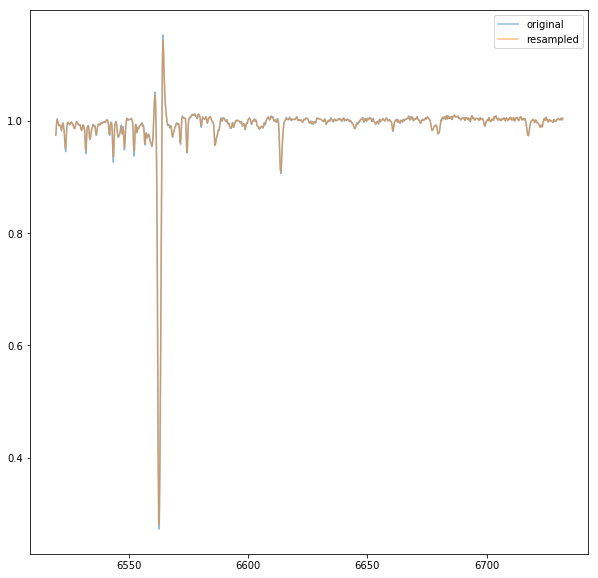

In [10]:
try_resampling_range(foo_waves.shape[0])

## Upsampling

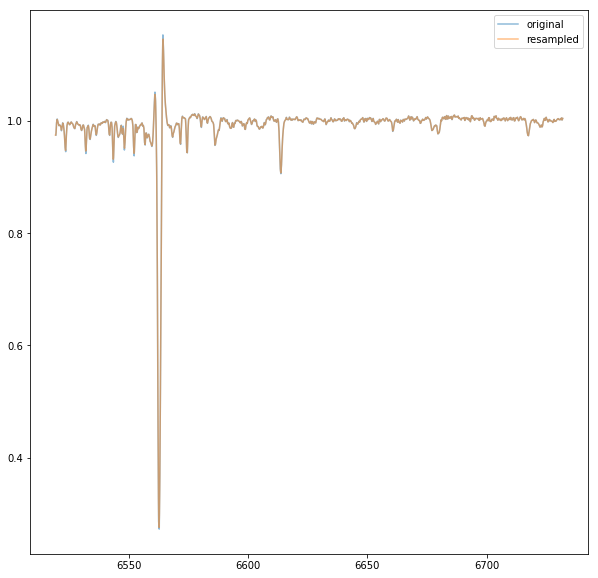

In [11]:
try_resampling_range(2 * foo_waves.shape[0])

## Downsampling

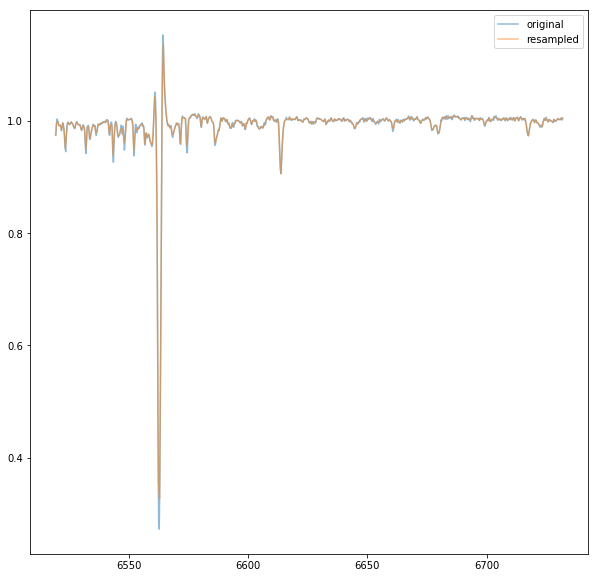

In [12]:
try_resampling_range(foo_waves.shape[0] // 2)

In [13]:
def waves_in_range(waves):
    return utils.cut_spectrum(waves[0], waves[1], START, END)[0].shape[0]

n_waves = max(map(waves_in_range, spectra.values()))

In [14]:
# remove spectra with uknown label
all_idents = [ident for ident in spectra if spectra[ident].attrs['label'] != 2]
n_samples = len(all_idents)

In [15]:
try:
    del f['X']
    del f['y']
    del f['idents']
except:
    pass

X = f.create_dataset('X', (n_samples, n_waves), dtype=np.float32)
y = f.create_dataset('y', (n_samples, ), dtype=np.int)
idents = f.create_dataset('idents', (n_samples, ), dtype=h5py.special_dtype(vlen=str))

In [16]:
space = np.linspace(START, END, num=n_waves)

for idx, ident in enumerate(all_idents):
    X[idx, :] = resample_spectrum(space, spectra[ident][0], spectra[ident][1])
    y[idx] = spectra[ident].attrs['label']
    idents[idx] = ident

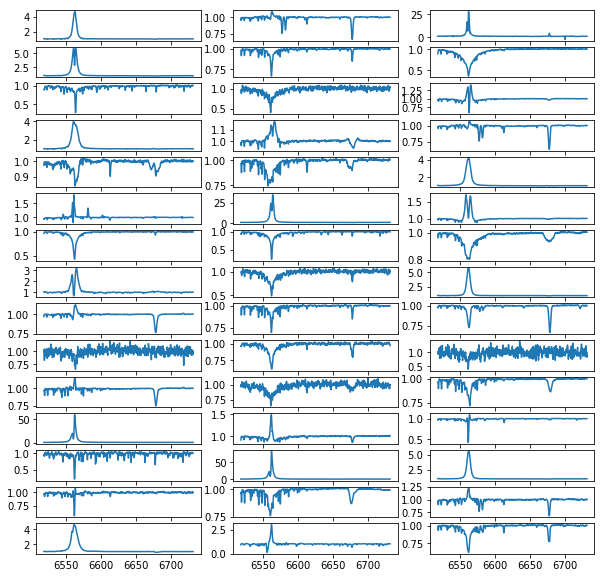

In [17]:
def random_preview(rows=15, cols=3):
    f, axs = plt.subplots(rows, cols, figsize=(10, 10))

    idxs = random.sample(range(n_samples), rows * cols)
    for idx, ax in zip(idxs, axs.ravel()):
        ax.plot(space, X[idx])

random_preview()

In [18]:
f.close()